In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.optimize import brute, minimize, fmin

import ROOT
from find_SN_dir import *

from tqdm import tqdm, trange
from multiprocessing import Pool
import multiprocessing as mp
%load_ext jupyternotify

Welcome to JupyROOT 6.26/10


<IPython.core.display.Javascript object>

In [2]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = [8,6]
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.visible'] = True

matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
# matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.sans-serif'] = 'Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial'
matplotlib.rcParams['font.serif'] = 'Tex Gyre Cursor, Courier, Courier New, Nimbus Mono, FreeMono'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif' 
matplotlib.rcParams['mathtext.default'] = 'regular'

In [3]:
pickle_path = "/media/linux_store/hep/data/pickles/event_pools.pkl"
ES_param = load_pdf_parameterized("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf_param.dat", name="ES")
ES_numeric = load_pdf_numeric("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf.dat", name="ES")
CC_numeric = load_pdf_numeric("/media/linux_store/hep/data/pdf/CC_gvkm_radiological_0201_pdf.dat", name="CC")

/media/linux_store/hep/SN_pointing_scripts/make_PDF/find_SN_dir/find_SN_dir.py:134: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=1`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  energy_binning = np.loadtxt(f, max_rows=1)
/media/linux_store/hep/SN_pointing_scripts/make_PDF/find_SN_dir/find_SN_dir.py:135: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=1`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for 

### Load in event pool
either by reading the root files, or reading pickle files (faster)

In [4]:
## Read from pickle
import pickle
with open(pickle_path, "rb") as f:
    [ES_event_pool, CC_event_pool] = pickle.load(f)

In [5]:
def run_reco(a, b, es_exp=82, cc_exp=864, e_thresh = 5, sn_dir=None):
    confusion_matrix = np.array([[a, 0.5], [b, 0.5]])
    expected_counts = get_expected_counts([es_exp, cc_exp], confusion_matrix, channel_id_list=[0])
    SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                                   synthetic=True, 
                                   with_radio=True, 
                                   expected_counts=expected_counts, 
                                   poisson_count=True,
                                   sn_dir=sn_dir,
                                  )
    res = brute(SN_pointer.loss, ([0, np.pi], [0, 2*np.pi]), args=(1e-4, e_thresh),
                Ns=10, full_output=False, workers=1, finish=fmin)
    return (error(SN_pointer, res))

In [171]:
# Run reco as a function of distance
NRUNS=100000
distance_scale = np.random.rand(NRUNS) + 0.5 # with respect to 10kpc
es_count = 82  / (distance_scale**2)
cc_count = 864 / (distance_scale**2)
distance = 10 * distance_scale

configs = [(1.0, 0.0, cES, cCC, 5) for (cES, cCC) in zip(es_count, cc_count)]
with Pool(mp.cpu_count()) as p:
    errors = p.starmap(run_reco, configs)
    


In [172]:
configs = [(0.86, 0.04, cES, cCC, 5) for (cES, cCC) in zip(es_count, cc_count)]
with Pool(mp.cpu_count()) as p:
    errors_real = p.starmap(run_reco, configs)

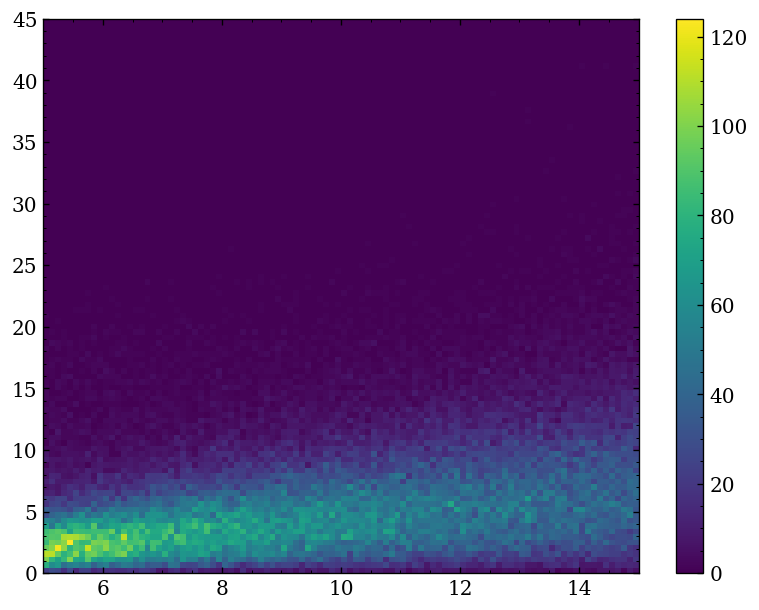

In [128]:
plt.hist2d(distance, errors, bins=100, range=[[5, 15], [0, 45]])
plt.colorbar()

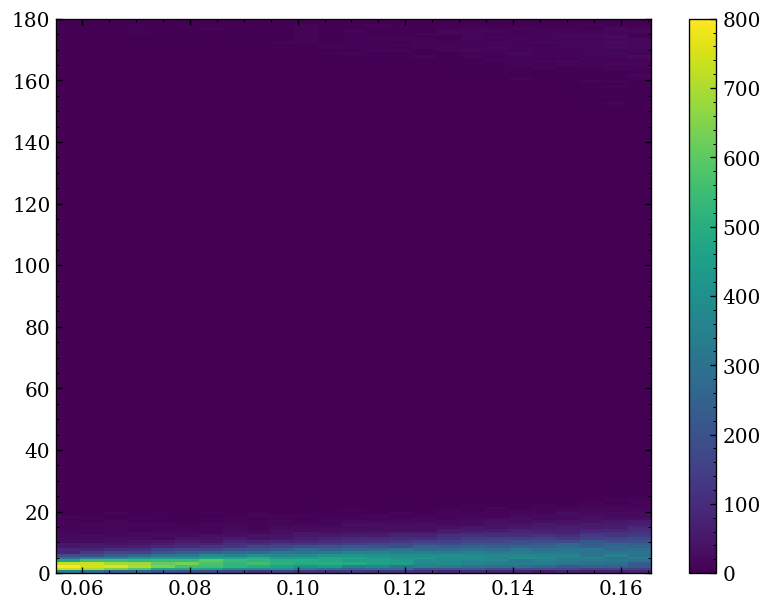

In [127]:
sqrtCountInverse = 1/np.sqrt(es_count)
h, x_edges, y_edges, _ = plt.hist2d(sqrtCountInverse, errors, bins=(25, 200), 
                                    range=[[np.min(sqrtCountInverse), np.max(sqrtCountInverse)], [0, 180]])
plt.colorbar()

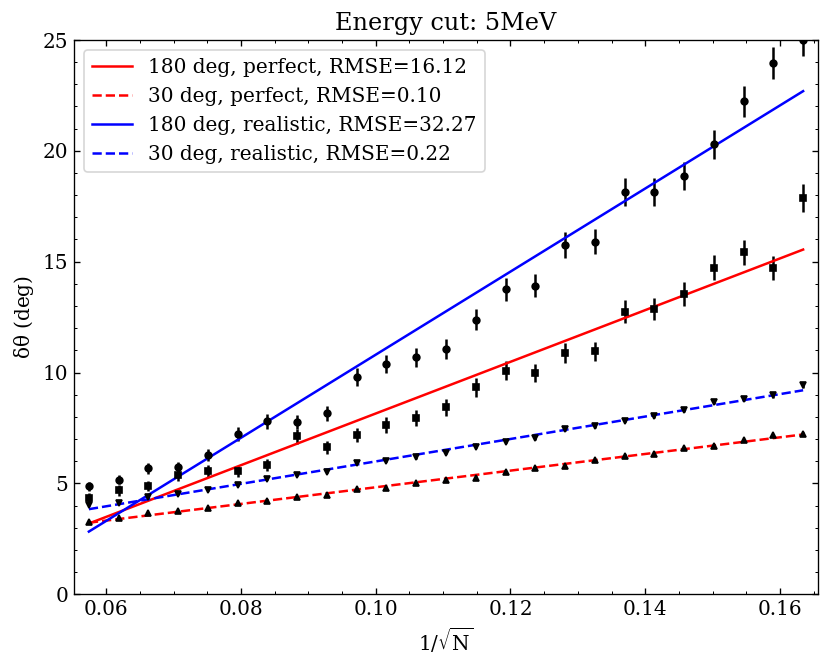

In [141]:
def sqrtNPlot(sqrtCountInverse, errors, thetaRange=180):
    h, x_edges, y_edges = np.histogram2d(sqrtCountInverse, errors, bins=(25, 200), 
                                     range=[[np.min(sqrtCountInverse), np.max(sqrtCountInverse)], [0, thetaRange]])
    x_centers = (x_edges[:-1] + x_edges[1:])/2
    y_centers = (y_edges[:-1] + y_edges[1:])/2
    h_mean = []
    h_error = []
    for col in h:
        mean = np.average(y_centers, weights=col)
        variance = np.average((y_centers-mean)**2, weights=col)
        h_mean.append(mean)
        h_error.append(np.sqrt(variance) / np.sqrt(np.sum(col)))
    coeff, res, _, _, _ = np.polyfit(x_centers, h_mean, 1, full=True)
    fit_func = np.poly1d(coeff)
    return x_centers, h_mean, h_error, fit_func, res[0]

sqrtCountInverse = 1/np.sqrt(es_count)
dataX, dataY, dataYerr, fit, res = sqrtNPlot(sqrtCountInverse, errors, thetaRange=180)
plt.errorbar(dataX, dataY, yerr=dataYerr, fmt='ks', markersize=4)
plt.plot(dataX, fit(dataX), 'r-', label=f"180 deg, perfect, RMSE={res:.2f}")

dataX, dataY, dataYerr, fit, res = sqrtNPlot(sqrtCountInverse, errors, thetaRange=90)
plt.errorbar(dataX, dataY, yerr=dataYerr, fmt='k^', markersize=4)
plt.plot(dataX, fit(dataX), 'r--', label=f"30 deg, perfect, RMSE={res:.2f}")

dataX, dataY, dataYerr, fit, res = sqrtNPlot(sqrtCountInverse, errors_real, thetaRange=180)
plt.errorbar(dataX, dataY, yerr=dataYerr, fmt='ko', markersize=4)
plt.plot(dataX, fit(dataX), 'b-', label=f"180 deg, realistic, RMSE={res:.2f}")

dataX, dataY, dataYerr, fit, res = sqrtNPlot(sqrtCountInverse, errors_real, thetaRange=90)
plt.errorbar(dataX, dataY, yerr=dataYerr, fmt='kv', markersize=4)
plt.plot(dataX, fit(dataX), 'b--', label=f"30 deg, realistic, RMSE={res:.2f}")


plt.ylabel(r"$\delta\theta$ (deg)")
plt.xlabel(r"$1/\sqrt{N}$")
plt.ylim(0, 25)
plt.xlim(np.min(sqrtCountInverse), np.max(sqrtCountInverse))
plt.title("Energy cut: 5MeV")
plt.legend()

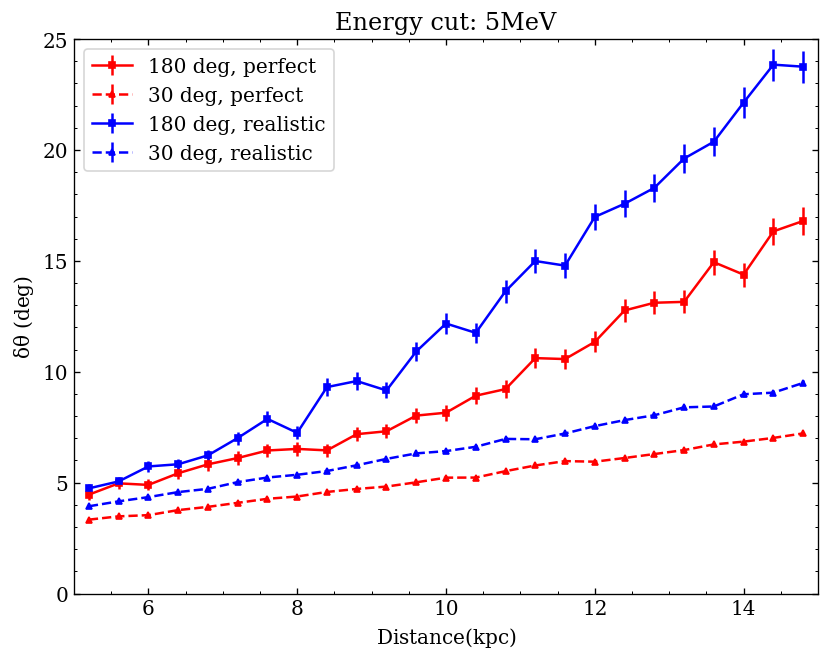

In [173]:
def distancePlot(distance, errors, thetaRange=180):
    h, x_edges, y_edges = np.histogram2d(distance, errors, bins=(25, 200), 
                                     range=[[np.min(distance), np.max(distance)], [0, thetaRange]])
    x_centers = (x_edges[:-1] + x_edges[1:])/2
    y_centers = (y_edges[:-1] + y_edges[1:])/2
    h_mean = []
    h_error = []
    for col in h:
        mean = np.average(y_centers, weights=col)
        variance = np.average((y_centers-mean)**2, weights=col)
        h_mean.append(mean)
        h_error.append(np.sqrt(variance) / np.sqrt(np.sum(col)))
    return x_centers, h_mean, h_error

dataX, dataY, dataYerr = distancePlot(distance, errors, thetaRange=180)
plt.errorbar(dataX, dataY, yerr=dataYerr, fmt='rs-', markersize=4, label="180 deg, perfect")

dataX, dataY, dataYerr = distancePlot(distance, errors, thetaRange=90)
plt.errorbar(dataX, dataY, yerr=dataYerr, fmt='r^--', markersize=4, label="30 deg, perfect")

dataX, dataY, dataYerr = distancePlot(distance, errors_real, thetaRange=180)
plt.errorbar(dataX, dataY, yerr=dataYerr, fmt='bs-', markersize=4, label="180 deg, realistic")

dataX, dataY, dataYerr = distancePlot(distance, errors_real, thetaRange=90)
plt.errorbar(dataX, dataY, yerr=dataYerr, fmt='b^--', markersize=4, label="30 deg, realistic")


plt.ylabel(r"$\delta\theta$ (deg)")
plt.xlabel(r"$Distance (kpc)$")
plt.ylim(0, 25)
plt.xlim(np.min(distance), np.max(distance))
plt.title("Energy cut: 5MeV")
plt.legend()

In [164]:
def random_worker():
    rng = np.random.default_rng()
    return rng.random(3)

with Pool(4) as p:
    res = p.starmap(random_worker,[() for i in range(16)] )

for r in res:
    print(r)

[0.71361177 0.81926592 0.15273498]
[0.8534806  0.84689861 0.09382329]
[0.06378435 0.42351645 0.12935215]
[0.11700432 0.1077415  0.47206542]
[0.73646038 0.70485044 0.30933351]
[0.37230827 0.46433126 0.13171929]
[0.87712681 0.62695173 0.72061562]
[0.2346686  0.60241098 0.10105793]
[0.78653072 0.99479215 0.54261349]
[0.10977684 0.33604555 0.92801052]
[0.26854099 0.31770761 0.68246196]
[0.0597351  0.21030398 0.28740803]
[0.46944691 0.30151125 0.03507599]
[0.56473997 0.76020538 0.40019606]
[0.85346387 0.72188445 0.99532587]
[0.07137068 0.27964771 0.38331439]
